In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error


In [3]:
female_births = pd.read_csv("../Lessons/lesson_1/Series/daily-total-female-births-in-cal.csv")
sales_of_company_x = pd.read_csv("../Lessons/lesson_1/Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("../Lessons/lesson_1/Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("../Lessons/lesson_1/Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("../Lessons/lesson_1/Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("../Lessons/lesson_1/Series/weekly-closings-of-the-dowjones-.csv")

In [4]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

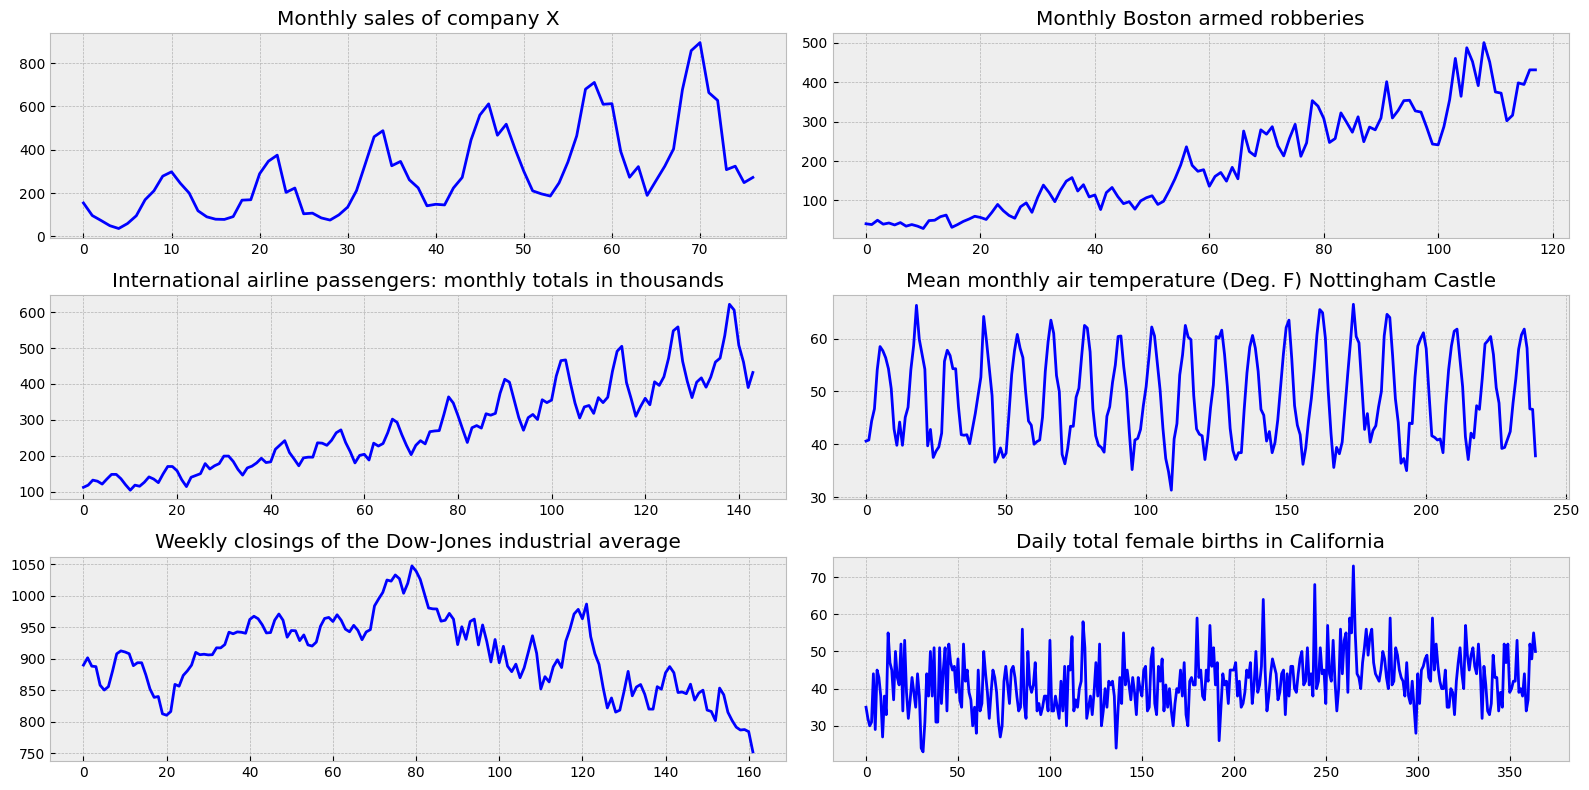

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

Возьмем стационарный ряд Daily total female births in California. Попробуем его предсказать. Будем использовать Ema поскольку у ряда нет ни сезонности ни тренда

In [23]:
series = all_series["Daily total female births in California"]

In [31]:
def exponential_moving_average(series, alpha, n_predictions=0):
    result = [series[0]]
    
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    
    
    last_value = result[-1]
    for _ in range(n_predictions):
        last_value = alpha * last_value + (1 - alpha) * last_value
        result.append(last_value)
    
    return pd.Series(result)



In [42]:
ser = exponential_moving_average(series, 0.7, 10)

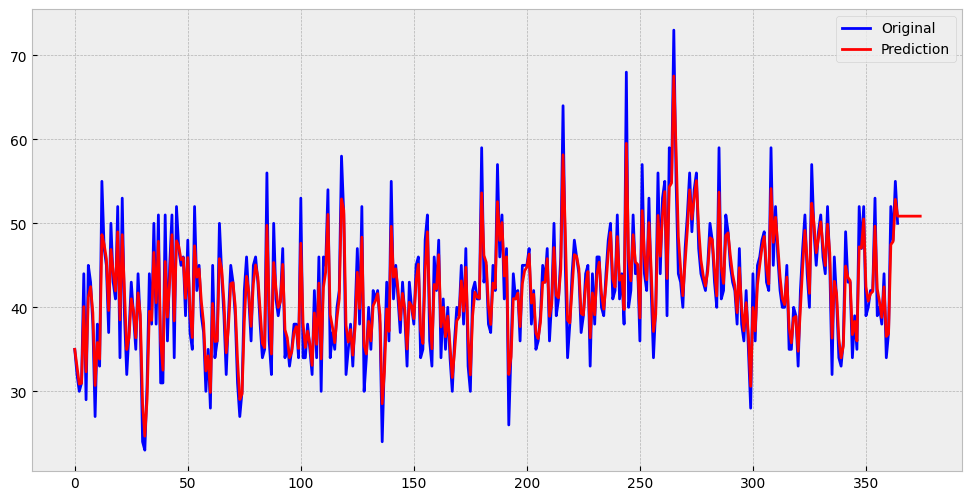

In [43]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 6))
    
    series.plot(color='blue', label = 'Original')
    ser.plot(color='red', linewidth='2', label = 'Prediction')
    
    plt.legend()

Нестационарный ряд будем предсказывать с помощью метода Хольта-Винтерса, поскольку у ряда присутствует сезонность и тренд

In [44]:
series = all_series['International airline passengers: monthly totals in thousands']

In [45]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [46]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [49]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [52]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=12):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

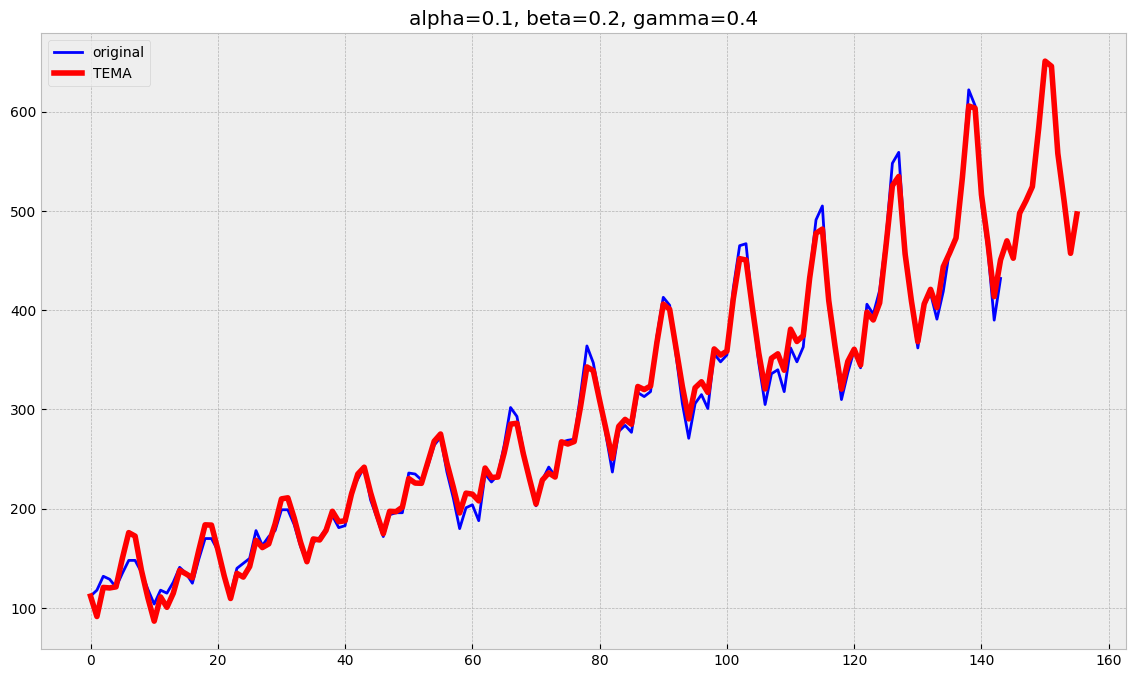

In [53]:
plot_tema(0.1, 0.2, 0.4)

Оптимизируем параметры с помощью RMSE

In [58]:
len(series)

144

In [59]:
train, test, val = series[:60], series[60:70], series[70:]

In [60]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [61]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [62]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 175.56063338594936
        x: [ 2.365e-03  9.920e-01  0.000e+00]
      nit: 139
      jac: [-6.907e+00 -1.026e-01  1.706e+01]
     nfev: 848
     njev: 212
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


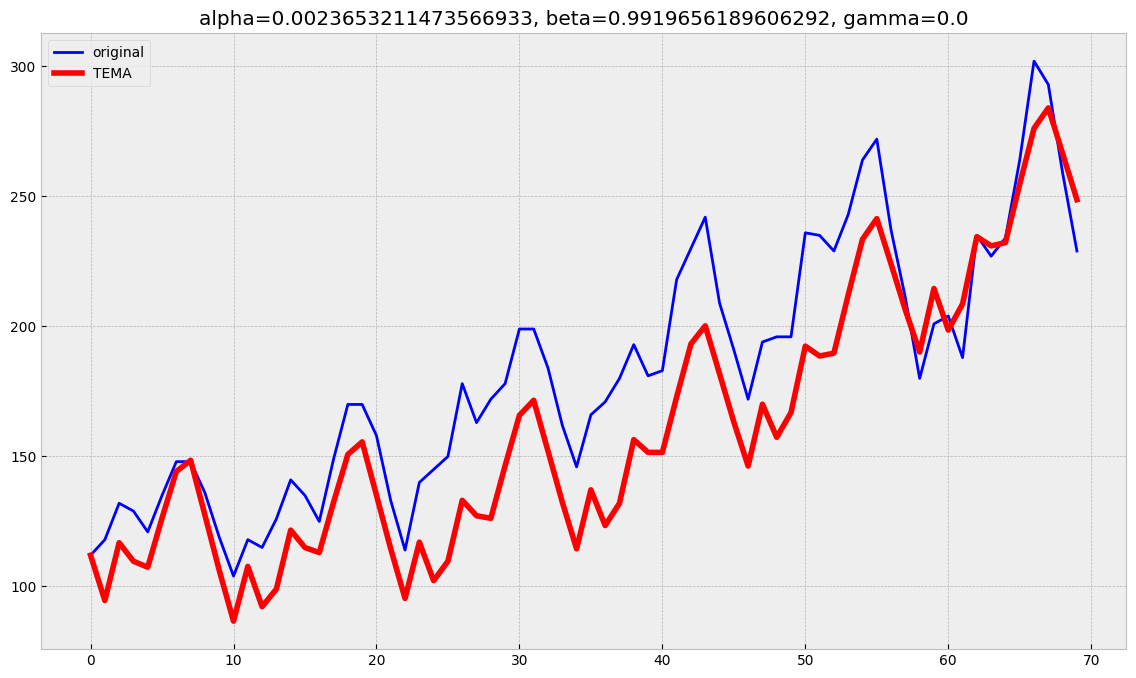

In [63]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

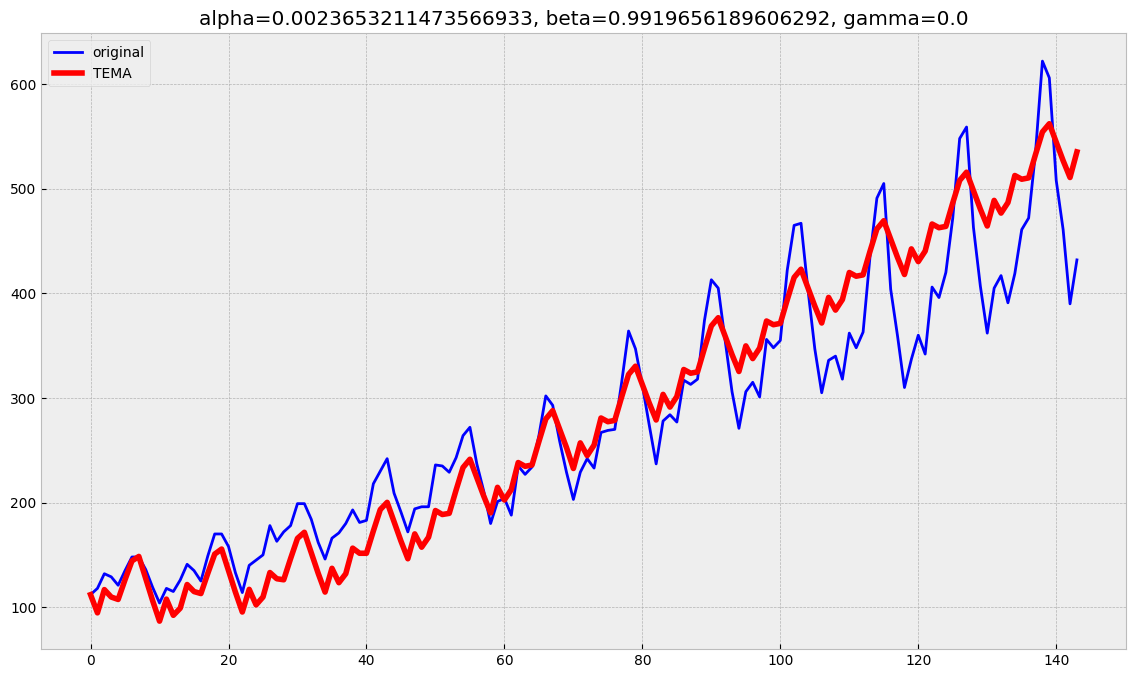

In [64]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))